**Description of the Project**
This project implements an image classification model to classify images as either "indoor" or "outdoor" based on visual features extracted from the images. It uses a combination of machine learning models, including Decision Trees, Random Forest, XGBoost, and semi-supervised learning methods for improved accuracy on limited labeled data. The project also demonstrates techniques such as feature extraction using Histogram of Oriented Gradients (HOG), color histograms, and Local Binary Patterns (LBP) to enhance the model’s performance.

**Requirements to Run the Python Code:**
To run the provided Python code, the following libraries are required:

Scikit-learn: For machine learning models, feature extraction, and data preprocessing.
OpenCV: For image manipulation, including resizing and grayscale conversion.
Joblib: To load and save trained models and scalers.
Numpy: For efficient numerical computations.
Matplotlib (optional): For visualizations.
Scikit-image: For extracting HOG features from images.

**Source Code Package in Scikit-learn and PyTorch:**
This project leverages Scikit-learn for traditional machine learning models (e.g., Decision Tree, Random Forest, XGBoost), along with feature extraction techniques such as HOG, color histograms, and LBP. The source code for this project includes:

Model Training and Evaluation: Code for training and evaluating the models using Scikit-learn.
Feature Extraction: Code for extracting HOG, LBP, and color histograms from images.
Preprocessing: Code for preprocessing images (resizing, grayscale conversion, etc.).
Prediction: Code for making predictions on new images using the pre-trained model.
If you would like to extend the project to use deep learning techniques, you can explore using PyTorch for building a neural network-based model. However, this code is currently implemented using Scikit-learn for simplicity and efficiency

In [ ]:
import os
import numpy as np
import cv2
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import xgboost as xgb
import cupy as cp  # To ensure GPU computation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from skimage.feature import local_binary_pattern



**Prepare your dataset:** The dataset should consist of labeled images. For this project, you can use the Places365 dataset or any similar dataset of images classified as "indoor" and "outdoor".

**Description on How to Obtain the Dataset from an Available Download Link:**
For this project, we recommend using the Places365 dataset, which can be downloaded from Places365. This dataset contains 10 million images across 365 scene categories, with an option to download smaller validation sets.

Alternatively, you can use your own labeled dataset of images classified as "indoor" and "outdoor."

To download the dataset, follow these steps:

Go to the Places365 website.
Register for access (if required).
Download the dataset or the validation images.
Ensure the dataset is split into two directories: one for indoor images and one for outdoor images.
After downloading the dataset, make sure that the images are organized and ready for preprocessing and model training.

In [3]:
DATASET_PATH = "/kaggle/input/training/Training"
DATASET_PATH_TEST = "/kaggle/input/testing/Museum_Validation"

**Preprocessing:** The preprocessing steps include image resizing, grayscale conversion, and feature extraction (HOG, color histograms, and LBP). This is done for both training and test datasets to ensure consistency.

In [4]:
def image_hash(image):
    """Generate a hash for an image to detect duplicates."""
    return hashlib.md5(image.tobytes()).hexdigest()

In [5]:
def preprocess_images(dataset_path):
    labels = []
    features = []
    brightness_values = []
    edge_densities = []
    seen_hashes = set()  # Track seen images to remove duplicates

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            # Skip corrupt or unreadable images
            if image is None:
                print(f"Warning: Skipping unreadable image {image_path}")
                continue

            # Resize image
            image = cv2.resize(image, (128, 128))

            # Check for duplicate images
            img_hash = image_hash(image)
            if img_hash in seen_hashes:
                print(f"Skipping duplicate image: {image_path}")
                continue
            seen_hashes.add(img_hash)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Compute brightness (normalized)
            brightness = np.mean(image) / 255.0  # Scale to [0,1]
            brightness_values.append(brightness)

            # Compute edge density (normalized)
            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges) / (image.size * 255.0)  # Scale to [0,1]
            edge_densities.append(edge_density)

            # Extract features
            color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform").flatten()
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            # Combine all features
            feature_vector = np.hstack([color_hist, lbp, hog_features, brightness, edge_density])
            features.append(feature_vector)

            # Assign label: 0 for Indoor, 1 for Outdoor
            labels.append(0 if category.lower() == "museum-indoor" else 1)

    # Convert lists to numpy arrays
    X = np.array(features)
    y = np.array(labels)

    # # Standardize features (for better ML performance)
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)

    # Print class distribution
    class_counts = Counter(y)
    print("Class distribution:", class_counts)

    return X, y, brightness_values, edge_densities



In [6]:
# Preprocess images and extract features
X, y, brightness_values, edge_densities = preprocess_images(DATASET_PATH)

Skipping duplicate image: /kaggle/input/training/Training/museum-outdoor/00001121.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00001569.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000289.jpg
Skipping duplicate image: /kaggle/input/training/Training/museum-indoor/00000635.jpg
Class distribution: Counter({1: 4999, 0: 4997})


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Assuming you've already fit and transformed your training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

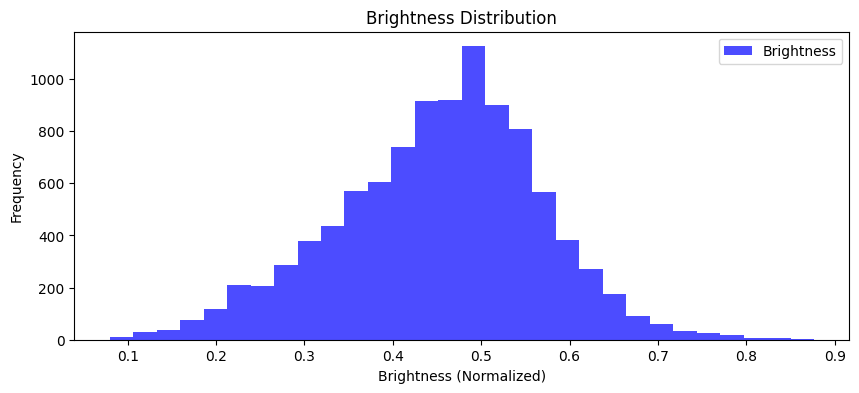

In [7]:
# EDA Visualizations
plt.figure(figsize=(10, 4))
plt.hist(brightness_values, bins=30, color='blue', alpha=0.7, label='Brightness')
plt.xlabel("Brightness (Normalized)")
plt.ylabel("Frequency")
plt.title("Brightness Distribution")
plt.legend()
plt.show()

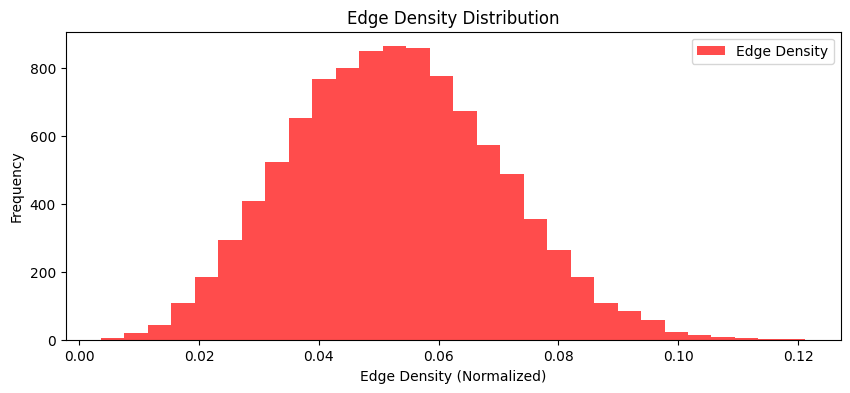

In [8]:
plt.figure(figsize=(10, 4))
plt.hist(edge_densities, bins=30, color='red', alpha=0.7, label='Edge Density')
plt.xlabel("Edge Density (Normalized)")
plt.ylabel("Frequency")
plt.title("Edge Density Distribution")
plt.legend()
plt.show()

In [9]:
def display_sample_images(dataset_path, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))  # 2 rows for 2 categories
    class_labels = ["Indoor", "Outdoor"]

    categories = os.listdir(dataset_path)
    categories = sorted([cat for cat in categories if os.path.isdir(os.path.join(dataset_path, cat))])  # Ensure order

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = [img for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]

        for j, image_name in enumerate(images):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Skipping unreadable image: {image_path}")
                continue
            
            image = cv2.resize(image, (128, 128))  # Resize for consistency
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)  # Apply histogram equalization

            axes[i, j].imshow(gray, cmap="gray")
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{class_labels[i]} {j+1}")

    plt.suptitle("Sample Preprocessed Images from Each Class")
    plt.show()




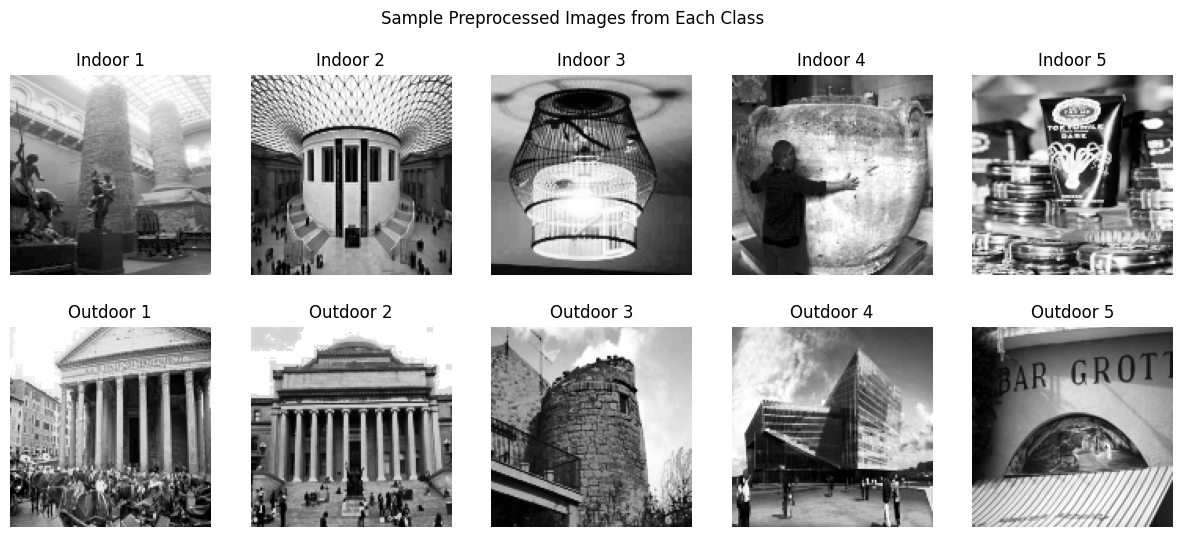

In [10]:
# Call function with dataset path
display_sample_images(DATASET_PATH)

**Train your model:** Train your model using the feature set extracted from the training images and will perform hyperparameter tuning where applicable (e.g., using GridSearchCV).

In [ ]:
# Function: Train and Evaluate Model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n🔹 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(model, f"{model_name}.pkl")

In [ ]:
# Hyperparameter Tuning Function
def tune_hyperparameters(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

Best parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}

🔹 Results for DecisionTree
Accuracy: 0.8045
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      1000
           1       0.80      0.81      0.80      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



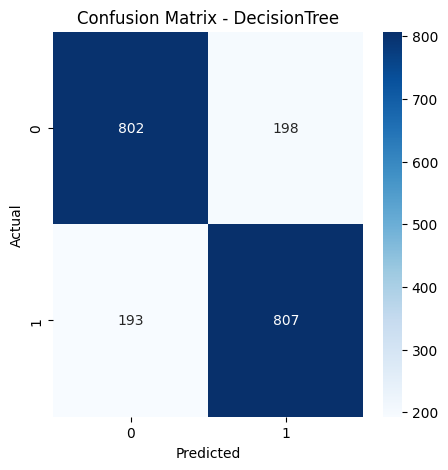

In [13]:
# 1. Train Decision Tree with Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10]
}
best_dt = tune_hyperparameters(DecisionTreeClassifier(random_state=42), dt_param_grid, X_train, y_train, "DecisionTree")
train_and_evaluate_model(best_dt, X_train, y_train, X_test, y_test, "DecisionTree")


Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

🔹 Results for RandomForest
Accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       0.90      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



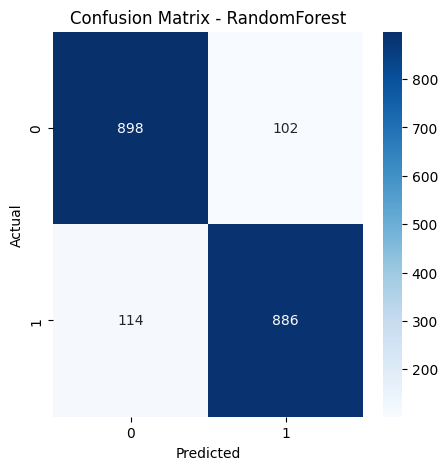

In [14]:
# 2. Train Random Forest with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
best_rf = tune_hyperparameters(RandomForestClassifier(random_state=42), rf_param_grid, X_train, y_train, "RandomForest")
train_and_evaluate_model(best_rf, X_train, y_train, X_test, y_test, "RandomForest")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:15:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.7}

🔹 Results for XGB
Accuracy: 0.9265
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       0.94      0.92      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



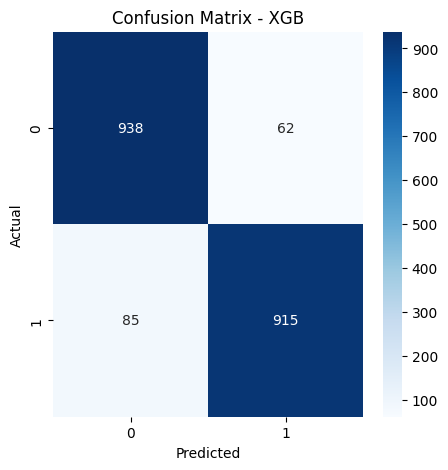

Model saved as XGB.pkl


In [15]:
# 3. Train XGB with Hyperparameter Tuning

# Move Data to GPU to Fix the Warning
def convert_to_dmatrix(X, y):
    return xgb.DMatrix(X, label=y, enable_categorical=True)  # Efficient memory use

# Hyperparameter Tuning with Safer Memory Management
def tune_hyperparameters_gpu(X_train, y_train, param_distributions, n_iter=10):
    xgb_model = xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', random_state=42,
        tree_method="hist", device="cuda", grow_policy="lossguide", max_bin=256
    )

    random_search = RandomizedSearchCV(
        xgb_model, param_distributions, n_iter=n_iter, cv=2, 
        n_jobs=1,  # FIX: Reduce memory pressure
        random_state=42
    )
    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    return random_search.best_estimator_

# Parameter Distributions (Optimized for Speed)
xgb_param_distributions = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.05, 0.1, 0.15],  
    'max_depth': [3, 4],  
    'subsample': [0.7, 0.8],  
    'colsample_bytree': [0.7, 0.8],  
    'gamma': [0, 0.1]
}

# Train and Evaluate (Fix Device Issue)
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # FIX: Convert Data to DMatrix and Move to GPU
    dtrain = convert_to_dmatrix(X_train, y_train)
    dtest = convert_to_dmatrix(X_test, y_test)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    print(f"\n🔹 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(model, f"/kaggle/working/{model_name}.pkl")
    print(f"Model saved as {model_name}.pkl")

# Run Training with Fixes
best_xgb_gpu = tune_hyperparameters_gpu(X_train, y_train, xgb_param_distributions, n_iter=10)
train_and_evaluate_model(best_xgb_gpu, X_train, y_train, X_test, y_test, "XGB")

 



In [16]:
# 4. Semi-Supervised Learning with Decision Tree
# Select only 20% labeled data, 80% unlabeled
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Train model on labeled data
semi_supervised_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
semi_supervised_dt.fit(X_labeled, y_labeled)

DecisionTreeClassifier(max_depth=10, random_state=42)


🔹 Results for SemiSupervisedDT
Accuracy: 0.971
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



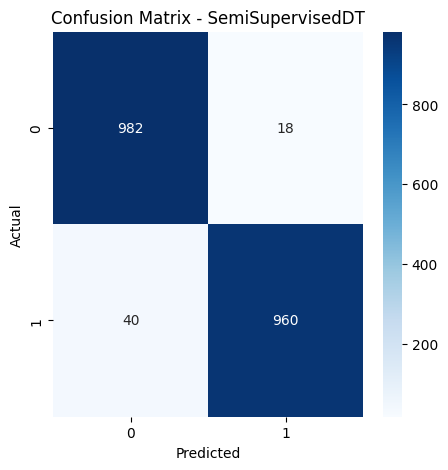

Model saved as SemiSupervisedDT.pkl


In [17]:
# Predict pseudo-labels for unlabeled data
pseudo_labels = semi_supervised_dt.predict(X_unlabeled)

# Select high-confidence predictions (probability >= 85%)
probabilities = semi_supervised_dt.predict_proba(X_unlabeled)
high_confidence = (probabilities.max(axis=1) >= 0.85)

X_high_confidence = X_unlabeled[high_confidence]
y_high_confidence = pseudo_labels[high_confidence]

# Add high-confidence pseudo-labels to training data
X_new_train = np.vstack((X_labeled, X_high_confidence))
y_new_train = np.hstack((y_labeled, y_high_confidence))

# Retrain model with expanded labeled dataset
semi_supervised_dt.fit(X_new_train, y_new_train)
train_and_evaluate_model(semi_supervised_dt, X_test, y_test, X_test, y_test, "SemiSupervisedDT")

**Evaluate your model:** After training, evaluate the model using the test data displaying the model's accuracy, precision, recall, and F1-score

In [18]:
# Load saved models
models = {
    "DecisionTree": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/DecisionTree.pkl"),
    "RandomForest": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/RandomForest.pkl"),
    # "SemiSupervisedDT": joblib.load("/kaggle/input/training-models/scikitlearn/default/1/SemiSupervisedDT.pkl"),
    "XGBoost": joblib.load("/kaggle/input/xgb4/scikitlearn/v4/1/XGB.pkl")
}

In [19]:
def preprocess_test_images(dataset_path):
    labels = []
    features = []
    brightness_values = []
    edge_densities = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Skipping unreadable image {image_path}")
                continue

            image = cv2.resize(image, (128, 128))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            brightness = np.mean(image) / 255.0
            brightness_values.append(brightness)

            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges) / (image.size * 255.0)
            edge_densities.append(edge_density)

            color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform").flatten()
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            feature_vector = np.hstack([color_hist, lbp, hog_features, brightness, edge_density])
            features.append(feature_vector)

            labels.append(0 if category.lower() == "museum-indoor" else 1)

    X_test = np.array(features)
    y_test = np.array(labels)

    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    return X_test, y_test

# Preprocess test images
X_test, y_test = preprocess_test_images(DATASET_PATH_TEST)


🔹 Evaluating Model: DecisionTree
Accuracy: 0.7700
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.75      0.80      0.78       100
     Outdoor       0.79      0.74      0.76       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200



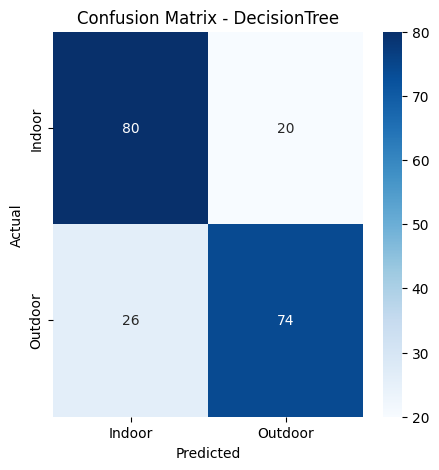


🔹 Evaluating Model: RandomForest
Accuracy: 0.8600
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.85      0.88      0.86       100
     Outdoor       0.88      0.84      0.86       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



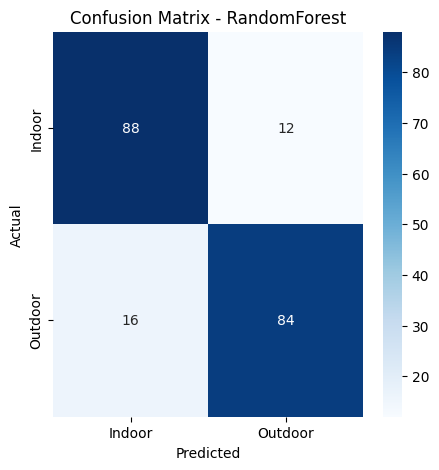


🔹 Evaluating Model: XGBoost
Accuracy: 0.9150
Classification Report:
               precision    recall  f1-score   support

      Indoor       0.92      0.91      0.91       100
     Outdoor       0.91      0.92      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



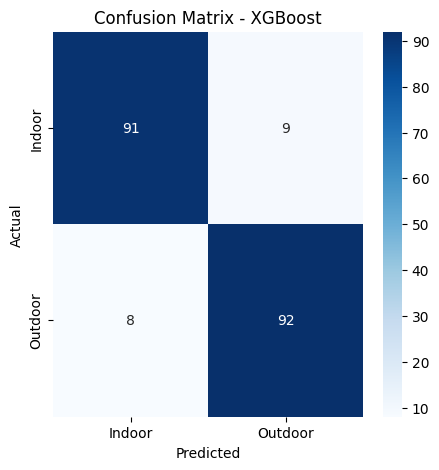

In [20]:
# Evaluate models
for model_name, model in models.items():
    print(f"\n🔹 Evaluating Model: {model_name}")
    
    # Predict on test dataset
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Indoor", "Outdoor"])
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    
    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


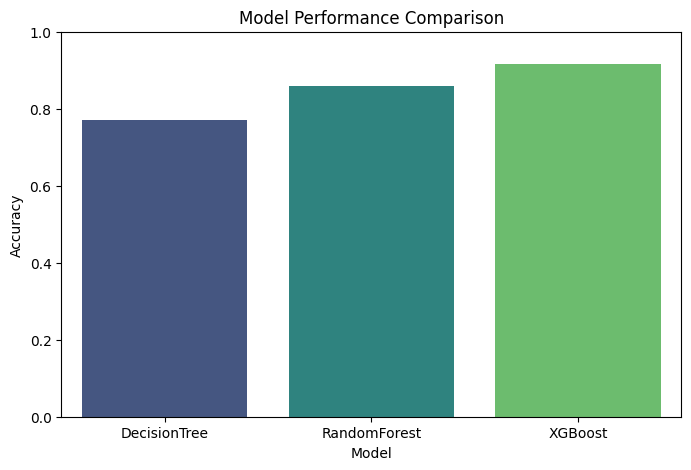

In [21]:
model_names = []
accuracies = []

# Store results for comparison
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_names.append(model_name)
    accuracies.append(accuracy)

# Plot model comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()